In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import json

# Ensure that matplotlib plots inline
%matplotlib inline


In [3]:
# Function to load JSONL file and extract the first 60 records
def load_jsonl_limited(filepath, limit=60):
    ground_truths = []
    responses = []
    with open(filepath, 'r') as file:
        for i, line in enumerate(file):
            if i >= limit:
                break
            record = json.loads(line.strip())
            ground_truths.append(record['ground_truth'])
            responses.append(record['response'])
    return pd.DataFrame({'ground_truth': ground_truths, 'response': responses})

# Paths to your JSONL files
file1_path = './llama-test-dataset-processed.jsonl'
file2_path = './llama-finetune-dataset-singleline-processed-2.jsonl'

df1_limited = load_jsonl_limited(file1_path, 60)
df2_limited = load_jsonl_limited(file2_path, 60)


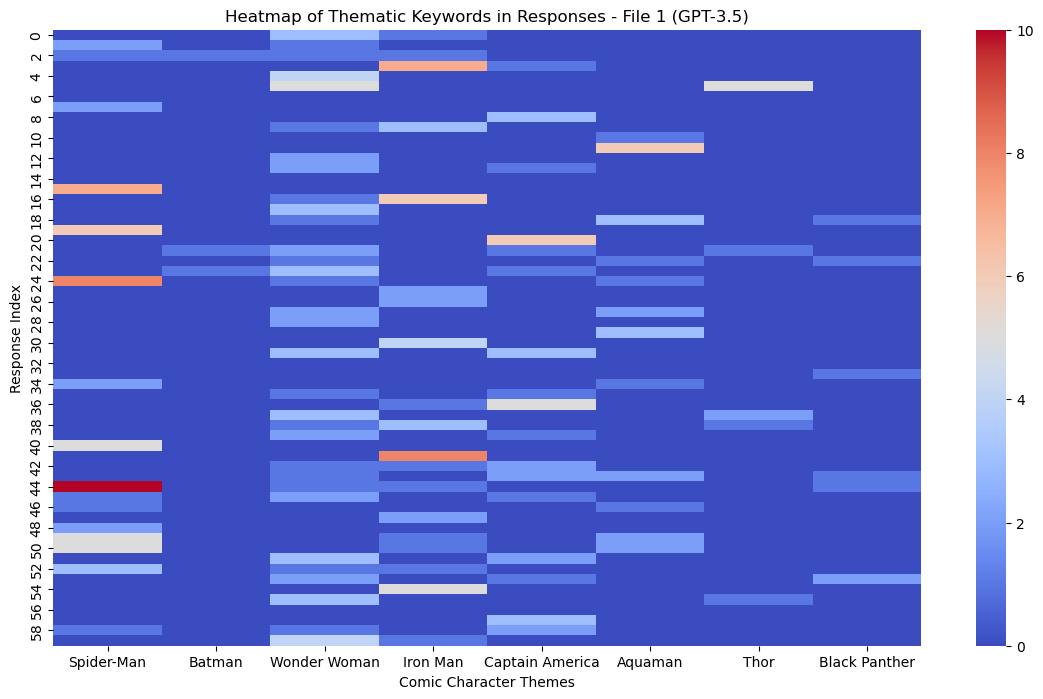

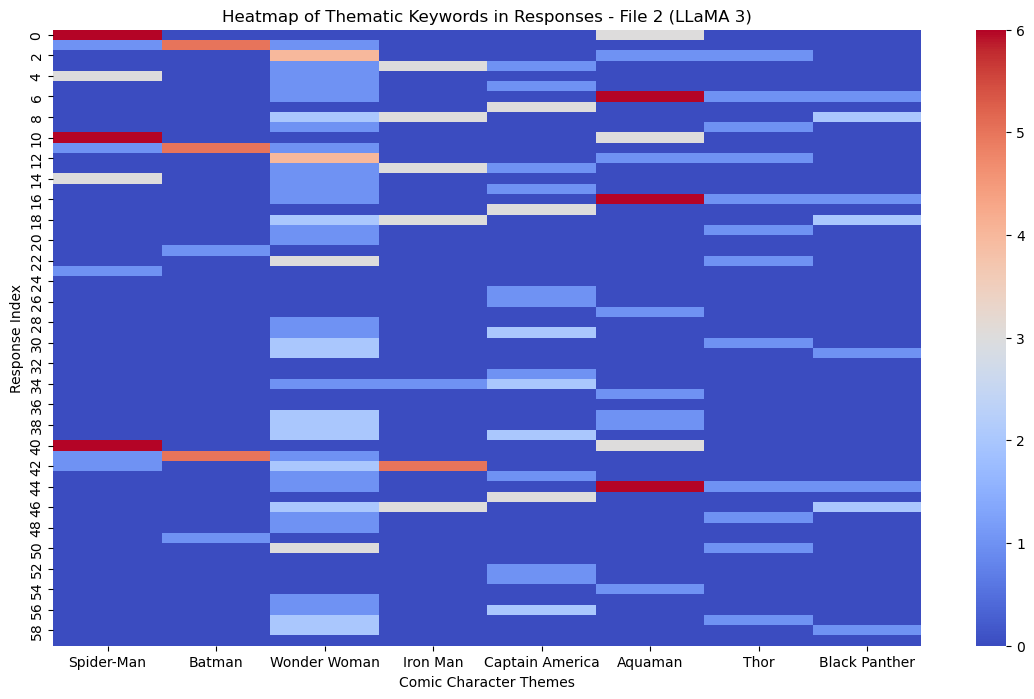

In [4]:
# Define thematic keywords for each comic character
thematic_keywords = {
    "Spider-Man": ["Spidey", "web", "swing", "city"],
    "Batman": ["Gotham", "signal", "allies", "crime"],
    "Wonder Woman": ["magical", "realm", "power", "nourish"],
    "Iron Man": ["arc", "reactor", "tech", "suit"],
    "Captain America": ["shield", "team", "mission", "battle"],
    "Aquaman": ["ocean", "kingdom", "marine", "water"],
    "Thor": ["Asgard", "Bifrost", "realm", "hammer"],
    "Black Panther": ["Wakanda", "vibranium", "kingdom", "strength"]
}

# Function to calculate thematic keyword coverage
def calculate_theme_coverage(df):
    data = {character: [] for character in thematic_keywords}
    for _, row in df.iterrows():
        response = row['response']
        for character, keywords in thematic_keywords.items():
            data[character].append(sum(response.lower().count(keyword) for keyword in keywords))
    return pd.DataFrame(data)

# Calculate thematic keyword coverage for both datasets
df1_keywords = calculate_theme_coverage(df1_limited)
df2_keywords = calculate_theme_coverage(df2_limited)

# Generate Heatmap of Thematic Keywords
plt.figure(figsize=(14, 8))
sns.heatmap(df1_keywords[thematic_keywords.keys()], annot=False, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Thematic Keywords in Responses - File 1 (GPT-3.5)')
plt.xlabel('Comic Character Themes')
plt.ylabel('Response Index')
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(df2_keywords[thematic_keywords.keys()], annot=False, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Thematic Keywords in Responses - File 2 (LLaMA 3)')
plt.xlabel('Comic Character Themes')
plt.ylabel('Response Index')
plt.show()


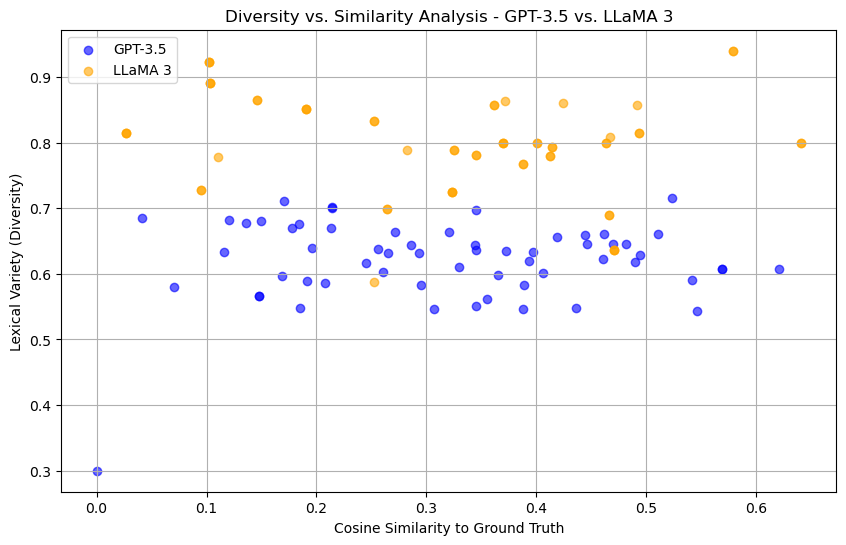

In [5]:
# Function to calculate similarity and diversity
def calculate_similarity_and_diversity(df):
    similarities = []
    diversities = []
    vectorizer = TfidfVectorizer().fit(df['ground_truth'] + df['response'])
    for _, row in df.iterrows():
        gt_vector = vectorizer.transform([row['ground_truth']])
        resp_vector = vectorizer.transform([row['response']])
        similarity = cosine_similarity(gt_vector, resp_vector)[0][0]
        similarities.append(similarity)
        diversity = len(set(row['response'].split())) / len(row['response'].split())
        diversities.append(diversity)
    return similarities, diversities

similarities1, diversities1 = calculate_similarity_and_diversity(df1_limited)
similarities2, diversities2 = calculate_similarity_and_diversity(df2_limited)

# Scatter plot for Diversity vs. Similarity
plt.figure(figsize=(10, 6))
plt.scatter(similarities1, diversities1, alpha=0.6, label='GPT-3.5', color='blue')
plt.scatter(similarities2, diversities2, alpha=0.6, label='LLaMA 3', color='orange')
plt.title('Diversity vs. Similarity Analysis - GPT-3.5 vs. LLaMA 3')
plt.xlabel('Cosine Similarity to Ground Truth')
plt.ylabel('Lexical Variety (Diversity)')
plt.legend()
plt.grid(True)
plt.show()


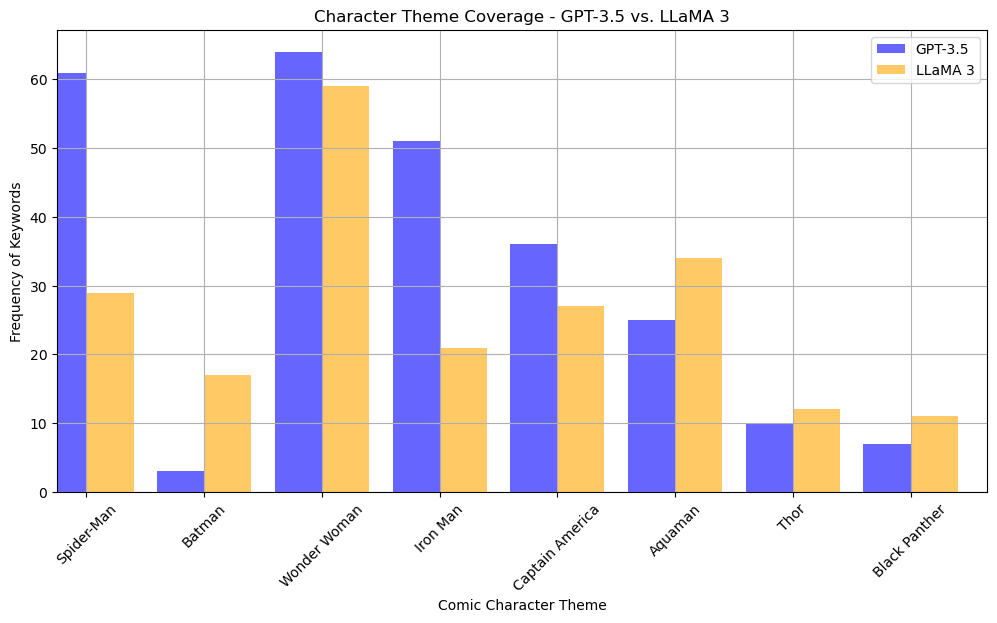

In [6]:
# Calculate overall thematic keyword frequency
theme_coverage1 = {character: sum(df1_keywords[character]) for character in thematic_keywords.keys()}
theme_coverage2 = {character: sum(df2_keywords[character]) for character in thematic_keywords.keys()}

# Convert to DataFrame for easy plotting
df_theme_coverage1 = pd.DataFrame(list(theme_coverage1.items()), columns=['Character Theme', 'Frequency']).set_index('Character Theme')
df_theme_coverage2 = pd.DataFrame(list(theme_coverage2.items()), columns=['Character Theme', 'Frequency']).set_index('Character Theme')

# Bar chart for Character Theme Coverage comparison
plt.figure(figsize=(12, 6))
df_theme_coverage1['Frequency'].plot(kind='bar', color='blue', alpha=0.6, position=1, width=0.4, label='GPT-3.5')
df_theme_coverage2['Frequency'].plot(kind='bar', color='orange', alpha=0.6, position=0, width=0.4, label='LLaMA 3')
plt.title('Character Theme Coverage - GPT-3.5 vs. LLaMA 3')
plt.xlabel('Comic Character Theme')
plt.ylabel('Frequency of Keywords')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [7]:
# Accuracy vs. Creativity: Cosine Similarity for Accuracy and Lexical Variety for Creativity
def calculate_accuracy_creativity(df):
    accuracies = []
    creativities = []
    vectorizer = TfidfVectorizer().fit(df['ground_truth'] + df['response'])
    for _, row in df.iterrows():
        gt_vector = vectorizer.transform([row['ground_truth']])
        resp_vector = vectorizer.transform([row['response']])
        accuracy = cosine_similarity(gt_vector, resp_vector)[0][0]
        accuracies.append(accuracy)
        creativity = len(set(row['response'].split())) / len(row['response'].split())
        creativities.append(creativity)
    return pd.DataFrame({'Accuracy': accuracies, 'Creativity': creativities})

accuracy_creativity1 = calculate_accuracy_creativity(df1_limited)
accuracy_creativity2 = calculate_accuracy_creativity(df2_limited)

# Topic Consistency vs. Drift: Cosine Similarity for Consistency and difference in TF-IDF for Drift
def calculate_topic_consistency_drift(df):
    consistencies = []
    drifts = []
    vectorizer = TfidfVectorizer().fit(df['ground_truth'] + df['response'])
    for _, row in df.iterrows():
        gt_vector = vectorizer.transform([row['ground_truth']])
        resp_vector = vectorizer.transform([row['response']])
        consistency = cosine_similarity(gt_vector, resp_vector)[0][0]
        drift = 1 - consistency  # Drift is the opposite of consistency
        consistencies.append(consistency)
        drifts.append(drift)
    return pd.DataFrame({'Topic Consistency': consistencies, 'Topic Drift': drifts})

topic_consistency_drift1 = calculate_topic_consistency_drift(df1_limited)
topic_consistency_drift2 = calculate_topic_consistency_drift(df2_limited)

# Calculate means
mean_accuracy_creativity1 = accuracy_creativity1.mean()
mean_accuracy_creativity2 = accuracy_creativity2.mean()

mean_topic_consistency_drift1 = topic_consistency_drift1.mean()
mean_topic_consistency_drift2 = topic_consistency_drift2.mean()

# Creating cross-tabs
cross_tab1 = pd.concat([mean_accuracy_creativity1, mean_topic_consistency_drift1], axis=0)
cross_tab2 = pd.concat([mean_accuracy_creativity2, mean_topic_consistency_drift2], axis=0)

cross_tab_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Creativity', 'Topic Consistency', 'Topic Drift'],
    'GPT-3.5': cross_tab1.values,
    'LLaMA 3': cross_tab2.values
})

# Display cross-tabs
cross_tab_comparison = cross_tab_comparison.round(2)
display(cross_tab_comparison)


,Metric,GPT-3.5,LLaMA 3
0,Accuracy,0.32,0.32
1,Creativity,0.62,0.80
2,Topic Consistency,0.32,0.32
3,Topic Drift,0.68,0.68
